## RiskEstimators class functions

This description is partially based on the __scikit-learn User Guide on Covariance estimation__ [available here](https://scikit-learn.org/stable/modules/covariance.html#robust-covariance).

## Introduction

Risk Estimators class includes the implementations of functions for different ways to calculate and adjust Covariance matrices.

The following algorithms are now implemented:
- Minimum Covariance Determinant
- Maximum likelihood covariance estimator (Empirical covariance)
- Covariance estimator with shrinkage
  - Basic shrinkage
  - Ledoit-Wolf shrinkage
  - Oracle Approximating Shrinkage
- Semi-Covariance matrix
- Exponentially-weighted Covariance matrix
- De-noising and De-toning Covariance/Correlation Matrix
  - Constant Residual Eigenvalue De-noising Method
  - Spectral Clustering De-noising Method
  - Targeted Shrinkage De-noising Method
  - Hierarchical Clustering De-noising Method
  - De-toning
- Transforming covariance matrix to correlation matrix and back

This Notebook will describe the above algorithms as well as provide use cases and analysis of results.

## Minimum Covariance Determinant

According to the __scikit-learn User Guide on Covariance estimation__:

_"The outliers are appearing in real data sets and seriously affect the Empirical covariance estimator and the Covariance estimators with shrinkage. For this reason, a robust covariance estimator is needed in order to discard/downweight the outliers in the data"._

The robust estimator presented in the package is the Minimum Covariance Determinant estimator, introduced by P.J. Rousseeuw.

_"The basic idea of the algorithm is to find a set of observations that are not outliers and compute their empirical covariance matrix, which is then rescaled to compensate for the performed selection of observations"._

Our function is a wrap around the sklearn's MinCovDet class, which uses FastMCD algorithm, developed by Rousseeuw and Van Driessen.

A detailed description of the algorithm is available in the paper by _Mia Hubert_ and _Michiel Debruyne_ __Minimum covariance determinant__ [available here](https://wis.kuleuven.be/stat/robust/papers/2010/wire-mcd.pdf)

### Examples of use

We can calculate the Minimum Covariance Determinant estimator of covariance for a data set of stock prices and compare it to the simple covariance.

In [1]:
# import portfoliolab as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import yfinance as yf

tickers = "EEM EWG TIP EWJ EFA"

data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = tickers,

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "ytd",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

stock_prices = data.apply(lambda x: x.loc[:, 'Close'], axis='columns')
stock_prices.dropna(axis='columns')
stock_prices.head()

[*********************100%***********************]  5 of 5 completed


,TIP,EEM,EWJ,EWG,EFA
Date,,,,,
2022-01-03,126.965256,49.200001,67.029999,33.160000,79.190002
2022-01-04,126.480949,49.029999,67.910004,33.259998,79.639999
2022-01-05,125.453049,48.230000,67.599998,33.150002,78.940002
2022-01-06,124.909447,48.450001,67.099998,33.029999,78.540001
2022-01-07,124.761200,48.889999,66.669998,33.110001,78.769997


In [3]:
from risk_estimators import RiskEstimators
from returns_estimators import ReturnsEstimators

# A class that has the Minimum Covariance Determinant estimator
risk_estimators = RiskEstimators()

# Finding the Minimum Covariance Determinant estimator on price data and with set random seed to 0
min_cov_det = risk_estimators.minimum_covariance_determinant(stock_prices, price_data=True, random_state=0)

# For the simple covariance, we need to transform the stock prices to returns

# A class with function to calculate returns from prices
returns_estimation = ReturnsEstimators()

# Calcualting the data set of returns
stock_returns = returns_estimation.calculate_returns(stock_prices)

# Finding the simple covariance matrix from a series of returns
cov_matrix = stock_returns.cov()

# Transforming Minimum Covariance Determinant estimator from np.array to pd.DataFrame
min_cov_det = pd.DataFrame(min_cov_det, index=cov_matrix.index, columns=cov_matrix.columns)

print('The Minimum Covariance Determinant estimator is:')
min_cov_det

The Minimum Covariance Determinant estimator is:


/home/ahura/Financial Economics Project 1/Estimators/codes/risk_estimators.py:137: RuntimeWarning: data is not in a dataframe
  warnings.warn("data is not in a dataframe", RuntimeWarning)


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000018,-0.000007,-0.000006,-0.000013,-0.000010
EEM,-0.000007,0.000180,0.000120,0.000161,0.000129
EWJ,-0.000006,0.000120,0.000137,0.000123,0.000112
EWG,-0.000013,0.000161,0.000123,0.000188,0.000144
EFA,-0.000010,0.000129,0.000112,0.000144,0.000122


In [4]:
print('The Simple Covariance is:')
cov_matrix

The Simple Covariance is:


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000032,-0.000020,-0.000016,-0.000049,-0.000028
EEM,-0.000020,0.000290,0.000153,0.000252,0.000190
EWJ,-0.000016,0.000153,0.000153,0.000170,0.000142
EWG,-0.000049,0.000252,0.000170,0.000416,0.000257
EFA,-0.000028,0.000190,0.000142,0.000257,0.000183


From the results, the absolute values in the Minimum Covariance Determinant estimator are lower in comparison to the simple Covariance matrix, which means that the algorithm has eliminated some of the outliers in the data and the resulting covariance matrix estimator is a more robust one.

## Maximum likelihood covariance estimator (Empirical covariance)

According to the __scikit-learn User Guide on Covariance estimation__:

_"The covariance matrix of a data set can be well approximated by the maximum likelihood estimator (Empirical covariance) if the number of observations is big enough in relation to the number of features"._

_"The Maximum Likelihood Estimator of a sample is an unbiased estimator of the corresponding population’s covariance matrix"._

### Examples of use

We can calculate the Empirical covariance for a data set of stock prices and compare it to the simple covariance.

In [5]:
# Finding the Empirical Covariance on price data
empirical_cov = risk_estimators.empirical_covariance(stock_prices, price_data=True)

# Transforming Empirical Covariance from np.array to pd.DataFrame
empirical_cov = pd.DataFrame(empirical_cov, index=cov_matrix.index, columns=cov_matrix.columns)

print('The Empirical Covariance is:')
empirical_cov

The Empirical Covariance is:


/home/ahura/Financial Economics Project 1/Estimators/codes/risk_estimators.py:187: RuntimeWarning: data is not in a dataframe
  warnings.warn("data is not in a dataframe", RuntimeWarning)


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000032,-0.000020,-0.000016,-0.000048,-0.000028
EEM,-0.000020,0.000286,0.000150,0.000248,0.000187
EWJ,-0.000016,0.000150,0.000151,0.000167,0.000140
EWG,-0.000048,0.000248,0.000167,0.000410,0.000254
EFA,-0.000028,0.000187,0.000140,0.000254,0.000181


In [6]:
print('The Simple Covariance is:')
cov_matrix

The Simple Covariance is:


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000032,-0.000020,-0.000016,-0.000049,-0.000028
EEM,-0.000020,0.000290,0.000153,0.000252,0.000190
EWJ,-0.000016,0.000153,0.000153,0.000170,0.000142
EWG,-0.000049,0.000252,0.000170,0.000416,0.000257
EFA,-0.000028,0.000190,0.000142,0.000257,0.000183


The result is the same as from the standard covariance function from the pandas package.

## Covariance estimator with shrinkage

According to the __scikit-learn User Guide on Covariance estimation__:

_"The Maximum Likelihood Estimator is not a good estimator of the eigenvalues of the covariance matrix and the inverted matrix is not accurate. Sometimes, ... it cannot be inverted for numerical reasons"._

_"To avoid problems with inversion, a transformation of the empirical covariance matrix has been introduced: the shrinkage"._

_"Mathematically, this shrinkage consists in reducing the ratio between the smallest and the largest eigenvalues of the empirical covariance matrix"._

### Basic shrinkage

_"This shrinkage is done by shifting every eigenvalue according to a given offset, which is equivalent to finding the l2-penalized Maximum Likelihood Estimator of the covariance matrix"._

_"Shrinkage boils down to a simple a convex transformation":_

$$\sum_{shrunk} = (1 - \alpha)\sum_{unshrunk} + \alpha\frac{Tr \sum_{unshrunk}}{p}Id$$

_"The amount of shrinkage $\alpha$ is setting a trade-off between bias and variance"._

In the implementation, $\alpha$ is passed to a function as the $basic\_shrinkage$ parameter.

### Ledoit-Wolf shrinkage

_"The Ledoit-Wolf shrinkage is based on computing the optimal shrinkage coefficient $\alpha$ that minimizes the Mean Squared Error between the estimated and the real covariance matrix"._

The algorithm is described in more detail in the paper by _Olivier Ledoit_ and _Michael Wolf_ __A well-conditioned estimator forlarge-dimensional covariance matrices__ [available here](http://perso.ens-lyon.fr/patrick.flandrin/LedoitWolf_JMA2004.pdf)

### Oracle Approximating shrinkage

_"Assuming that the data are Gaussian distributed, Chen et al. derived a formula aimed at choosing a shrinkage coefficient $\alpha$ that yields a smaller Mean Squared Error than the one given by Ledoit and Wolf’s formula"._

_"The resulting estimator is known as the Oracle Shrinkage Approximating estimator of the covariance"._

The algorithm is described in more detail in the paper by _Y. Chen_, _A. Wiesel_, _Y.C. Eldar_ and _A.O. Hero_ __Shrinkage Algorithms for MMSE Covariance Estimation__ [available here](https://webee.technion.ac.il/people/YoninaEldar/104.pdf)

### Examples of use

We can calculate the Shrinked Covariances for every method and compare them.

In [7]:
# Finding the Shrinked Covariances on price data with every method
shrinked_cov_methods = ['basic', 'lw', 'oas']
shrinked_cov_dict = dict()

for method in shrinked_cov_methods:
    shrinked_cov = risk_estimators.shrinked_covariance(
        stock_prices, 
        price_data=True,
        shrinkage_type=method,
        basic_shrinkage=0.1
        )
    
    shrinked_cov_dict[method] = shrinked_cov

# Separating the Shrinked covariances for every method
shrinked_cov_basic, shrinked_cov_lw, shrinked_cov_oas = shrinked_cov_dict['basic'], shrinked_cov_dict['lw'], shrinked_cov_dict['oas']

# Transforming each Shrinked Covariance from np.array to pd.DataFrame
shrinked_cov_basic = pd.DataFrame(shrinked_cov_basic, index=cov_matrix.index, columns=cov_matrix.columns)
shrinked_cov_lw = pd.DataFrame(shrinked_cov_lw, index=cov_matrix.index, columns=cov_matrix.columns)
shrinked_cov_oas = pd.DataFrame(shrinked_cov_oas, index=cov_matrix.index, columns=cov_matrix.columns)

print('The Basic Shrinked covariance with an alpha of 0.1 is:')
shrinked_cov_basic

The Basic Shrinked covariance with an alpha of 0.1 is:


/home/ahura/Financial Economics Project 1/Estimators/codes/risk_estimators.py:240: RuntimeWarning: data is not in a dataframe
  warnings.warn("data is not in a dataframe", RuntimeWarning)
/home/ahura/Financial Economics Project 1/Estimators/codes/risk_estimators.py:240: RuntimeWarning: data is not in a dataframe
  warnings.warn("data is not in a dataframe", RuntimeWarning)
/home/ahura/Financial Economics Project 1/Estimators/codes/risk_estimators.py:240: RuntimeWarning: data is not in a dataframe
  warnings.warn("data is not in a dataframe", RuntimeWarning)


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000050,-0.000018,-0.000014,-0.000043,-0.000025
EEM,-0.000018,0.000278,0.000135,0.000223,0.000168
EWJ,-0.000014,0.000135,0.000157,0.000150,0.000126
EWG,-0.000043,0.000223,0.000150,0.000390,0.000228
EFA,-0.000025,0.000168,0.000126,0.000228,0.000184


In [8]:
print('The Ledoit-Wolf Shrinked covariance is:')
shrinked_cov_lw

The Ledoit-Wolf Shrinked covariance is:


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000049,-0.000018,-0.000014,-0.000044,-0.000025
EEM,-0.000018,0.000279,0.000136,0.000225,0.000169
EWJ,-0.000014,0.000136,0.000157,0.000151,0.000127
EWG,-0.000044,0.000225,0.000151,0.000391,0.000230
EFA,-0.000025,0.000169,0.000127,0.000230,0.000184


In [9]:
print('The Oracle Approximating Shrinked covariance is:')
shrinked_cov_oas

The Oracle Approximating Shrinked covariance is:


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000040,-0.000019,-0.000015,-0.000046,-0.000026
EEM,-0.000019,0.000282,0.000143,0.000236,0.000178
EWJ,-0.000015,0.000143,0.000154,0.000159,0.000133
EWG,-0.000046,0.000236,0.000159,0.000400,0.000242
EFA,-0.000026,0.000178,0.000133,0.000242,0.000182


In [10]:
print('The Simple Covariance is:')
cov_matrix

The Simple Covariance is:


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000032,-0.000020,-0.000016,-0.000049,-0.000028
EEM,-0.000020,0.000290,0.000153,0.000252,0.000190
EWJ,-0.000016,0.000153,0.000153,0.000170,0.000142
EWG,-0.000049,0.000252,0.000170,0.000416,0.000257
EFA,-0.000028,0.000190,0.000142,0.000257,0.000183


The Shrinked Covariance matrices for the Ledoit-Wolf and Oracle Approximating algorithms are similar with absolute covariance values in the Oracle Approximating covariance matrix being slightly bigger. With the basic Shrinkage covariance matrix with $\alpha = 0.1$, the absolute values are even smaller. The Simple Covariance matrix has the highest absolute values in comparison.

## Semi-Covariance matrix

Semi-covariance matrix is the way to measure the volatility of the negative returns or returns below a certain threshold. 

This measure can be used to decrease the negative volatility and is being more precise for this goal than the covariance matrix that measures both positive and negative variance. 

According to the __Minimum Downside Volatility Indices__ paper:

_"Each element in the Semi-Covariance matrix is calculated as:"_

$$SemiCov_{ij} = \frac{1}{T}\sum_{t=1}^{T}[Min(R_{i,t}-B,0)*Min(R_{j,t}-B,0)]$$

_where $T$ is the number of observations,_ $R_{i,t}$ _is the return of an asset $i$ at time $t$, and $B$ is the threshold return._

_If the $B$ is set to zero, the volatility of negative returns is measured._

A deeper analysis of use cases of Semi-Covariance matrix is available in the paper by _Solactive AG - German Index Engineering_ __Minimum Downside Volatility Indices__ [available here](https://www.solactive.com/wp-content/uploads/2018/04/Solactive_Minimum-Downside-Volatility-Indices.pdf)

### Examples of use

We can calculate the Semi-Covariance and compare it to the simple covariance.

In [11]:
# Finding the Semi-Covariance on price data
semi_cov = risk_estimators.semi_covariance(stock_prices, price_data=True, threshold_return=0)

# Transforming Semi-Covariance from np.array to pd.DataFrame
semi_cov = pd.DataFrame(semi_cov, index=cov_matrix.index, columns=cov_matrix.columns)

print('The Semi-Covariance matrix is:')
semi_cov

The Semi-Covariance matrix is:


/home/ahura/Financial Economics Project 1/Estimators/codes/risk_estimators.py:297: RuntimeWarning: data is not in a dataframe
  warnings.warn("data is not in a dataframe", RuntimeWarning)


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000016,0.000018,0.000013,0.000013,0.000011
EEM,0.000018,0.000115,0.000078,0.000129,0.000090
EWJ,0.000013,0.000078,0.000089,0.000098,0.000075
EWG,0.000013,0.000129,0.000098,0.000216,0.000135
EFA,0.000011,0.000090,0.000075,0.000135,0.000092


In [12]:
print('The Simple Covariance is:')
cov_matrix

The Simple Covariance is:


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000032,-0.000020,-0.000016,-0.000049,-0.000028
EEM,-0.000020,0.000290,0.000153,0.000252,0.000190
EWJ,-0.000016,0.000153,0.000153,0.000170,0.000142
EWG,-0.000049,0.000252,0.000170,0.000416,0.000257
EFA,-0.000028,0.000190,0.000142,0.000257,0.000183


As the computation of the Semi-Covariance matrix is different from the usual computation of the covariance matrix, the absolute values in the Semi-Covariance matrix are significantly lower. Since it's a measure, let's multiply the Semi-Covariance matrix by 10 to better see the changes in the measures.

In [13]:
print('The Semi-Covariance matrix multiplied by 10 is:')
semi_cov * 10

The Semi-Covariance matrix multiplied by 10 is:


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000159,0.000175,0.000126,0.000128,0.000106
EEM,0.000175,0.001152,0.000781,0.001294,0.000895
EWJ,0.000126,0.000781,0.000891,0.000980,0.000746
EWG,0.000128,0.001294,0.000980,0.002159,0.001346
EFA,0.000106,0.000895,0.000746,0.001346,0.000921


Now we can see that the values in the two matrices are similar, however, some differences are present.

For example, the simple Covariance between the EEM and TIP is negative, but the negative returns have positive covariance. 

## Exponentially-weighted Covariance matrix

Each element in the Exponentially-weighted Covariance matrix is calculated as follows.

First, we calculate the series of covariances for every observation time $t$ between each two elements $i$ and $j$:

$$CovarSeries_{i,j}^{t} = (R_{i}^{t} - Mean(R_{i})) * (R_{j}^{t} - Mean(R_{j}))$$

Then we apply the exponential weighted moving average based on the obtained series with decay in terms of span, as $\alpha=\frac{2}{span+1}$, for $span \ge 1$

$$ExponentialCovariance_{i,j} = ExponentialWeightedMovingAverage(CovarSeries_{i,j})[T]$$

So, it's the last element from an exponentially weighted moving average series based on a series of covariances between returns of the corresponding assets. 

It is used to give greater weight to most relevant observations in computing the covariance.

### Examples of use

We can calculate the Exponential Covariance and compare it to the simple covariance.

In [14]:
# Finding the Exponential Covariance on price data and span of 60
exponential_cov = risk_estimators.exponential_covariance(stock_prices, price_data=True, window_span=60)

# Transforming Semi-Covariance from np.array to pd.DataFrame
exponential_cov = pd.DataFrame(exponential_cov, index=cov_matrix.index, columns=cov_matrix.columns)

print('The Exponential Covariance matrix is:')
exponential_cov

The Exponential Covariance matrix is:


/home/ahura/Financial Economics Project 1/Estimators/codes/risk_estimators.py:335: RuntimeWarning: data is not in a dataframe
  warnings.warn("data is not in a dataframe", RuntimeWarning)


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000032,-0.000022,-0.000017,-0.000049,-0.000029
EEM,-0.000022,0.000309,0.000163,0.000264,0.000198
EWJ,-0.000017,0.000163,0.000164,0.000184,0.000150
EWG,-0.000049,0.000264,0.000184,0.000438,0.000268
EFA,-0.000029,0.000198,0.000150,0.000268,0.000187


In [15]:
print('The Simple Covariance is:')
cov_matrix

The Simple Covariance is:


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000032,-0.000020,-0.000016,-0.000049,-0.000028
EEM,-0.000020,0.000290,0.000153,0.000252,0.000190
EWJ,-0.000016,0.000153,0.000153,0.000170,0.000142
EWG,-0.000049,0.000252,0.000170,0.000416,0.000257
EFA,-0.000028,0.000190,0.000142,0.000257,0.000183


From the results it's seen that the variance of the EWG has increased in the last observations, whereas the the variance of the EEM has decreased. The covariance between the EEM and EWJ has decreased in the last observations.

So, the covariance with higher weights in the most recent observations can be analyzed in comparison to covariance with equal weights (simple covariance). And the conclusions about how the covariance has changed over time can be drawn.

## De-noising and De-toning Covariance/Correlation Matrix

### Constant Residual Eigenvalue De-noising Method

The main idea behind de-noising the covariance matrix is to eliminate the eigenvalues of the covariance matrix that are representing noise and not useful information. 

This is done by determining the maximum theoretical value of the eigenvalue of such matrix as a threshold and then setting all the calculated eigenvalues below the threshold to the same value.

The function provided below for de-noising the covariance works as follows:
- The given covariance matrix is transformed to the correlation matrix.

- The eigenvalues and eigenvectors of the correlation matrix are calculated.

- Using the Kernel Density Estimate algorithm a kernel of the eigenvalues is estimated.

- The Marcenko-Pastur pdf is fitted to the KDE using the variance as the parameter for the optimization.

- From the obtained Marcenko-Pastur distribution, the maximum theoretical eigenvalue is calculated using the formula from the **Instability caused by noise** part of [A Robust Estimator of the Efficient Frontier paper](https://papers.ssrn.com/sol3/abstract_id=3469961).

- The eigenvalues in the set that are below the theoretical value are all set to their average value. For example, we have a set of 5 eigenvalues sorted in the descending order ( $\lambda_1 ... \lambda_5$ ), 3 of which are below the maximum theoretical value, then we set

$$\lambda_3^{NEW} = \lambda_4^{NEW} = \lambda_5^{NEW} = \frac{\lambda_3^{OLD} + \lambda_4^{OLD} + \lambda_5^{OLD}}{3}$$

- Eigenvalues above the maximum theoretical value are left intact.

$$\lambda_1^{NEW} = \lambda_1^{OLD}$$

$$\lambda_2^{NEW} = \lambda_2^{OLD}$$

- The new set of eigenvalues with the set of eigenvectors is used to obtain the new de-noised correlation matrix. $\tilde{C}$ is the de-noised correlation matrix, $W$ is the eigenvectors matrix, and $\Lambda$ is the diagonal matrix with new eigenvalues.

$$\tilde{C} = W \Lambda W$$

- To rescale $\tilde{C}$ so that the main diagonal consists of 1s the following transformation is made. This is how the final $C_{denoised}$ is obtained.

$$C_{denoised} = \tilde{C} [(diag[\tilde{C}])^\frac{1}{2}(diag[\tilde{C}])^{\frac{1}{2}'}]^{-1}$$

- The new correlation matrix is then transformed back to the new de-noised covariance matrix.

The process of de-noising the covariance matrix is described in a paper by _Potter M._, _J.P. Bouchaud_, _L. Laloux_ __“Financial applications of random matrix theory: Old laces and new pieces.”__  [available here](https://arxiv.org/abs/physics/0507111).

**Note: Lopez de Prado suggests that this de-noising algorithm is preferable as it removes the noise while preserving the signal.**

In [16]:
# Setting the required parameters for de-noising
# Relation of number of observations T to the number of variables N (T/N)

T, N = stock_prices.shape
tn_relation = T / N

# The bandwidth of the KDE kernel
kde_bwidth = 0.01


# Finding the De-noised Сovariance matrix using the Constant Residual Eigenvalue Method
cov_matrix_denoised = risk_estimators.denoise_covariance(cov_matrix,
                                                         tn_relation,
                                                         denoise_method='const_resid_eigen',
                                                         kde_bwidth=kde_bwidth)

# Transforming De-noised Covariance from np.array to pd.DataFrame
cov_matrix_denoised = pd.DataFrame(cov_matrix_denoised, index=cov_matrix.index, columns=cov_matrix.columns)

# Outputting the result
print('CRE De-noised Сovariance matrix')
cov_matrix_denoised

CRE De-noised Сovariance matrix


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000032,-0.000044,-0.000032,-0.000054,-0.000037
EEM,-0.000044,0.000290,0.000136,0.000229,0.000155
EWJ,-0.000032,0.000136,0.000153,0.000166,0.000113
EWG,-0.000054,0.000229,0.000166,0.000416,0.000189
EFA,-0.000037,0.000155,0.000113,0.000189,0.000183


In [17]:
print('The Simple Covariance is:')
cov_matrix

The Simple Covariance is:


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000032,-0.000020,-0.000016,-0.000049,-0.000028
EEM,-0.000020,0.000290,0.000153,0.000252,0.000190
EWJ,-0.000016,0.000153,0.000153,0.000170,0.000142
EWG,-0.000049,0.000252,0.000170,0.000416,0.000257
EFA,-0.000028,0.000190,0.000142,0.000257,0.000183


As we can see, the main diagonal hasn't changed, but the other covariances are different. This means that the algorithm has changed the eigenvalues of the correlation matrix.

### Spectral Clustering De-noising Method

The main idea behind spectral clustering is to remove the noise-related eigenvalues from an empirical correlation matrix, the method in which this is achieved is similar to the Constant Residual Eigenvalue de-noising method, the only difference is that instead of setting the eigenvalues which are below the theoretical value to their average value, they are set to zero in an attempt to remove the effects of those eigenvalues that are consistent with the null hypothesis of uncorrelated random variables.

Let us consider $n$ independent random variables with finite variance and $T$ records each. Random matrix
theory allows to prove that in the $\lim\limits_{n \to \infty} T$, with a fixed ratio $Q = T/n \geq 1$, the
eigenvalues of the sample correlation matrix cannot be larger than

$$ \lambda_{max} = \sigma^2(1 + \frac{1}{Q} + 2\sqrt{\frac{1}{Q}})$$

where $\sigma^2 = 1$ for correlation matrices, once achieved we set any eignevalues above this threshold to $0$.
For example, we have a set of 5 eigenvalues sorted in the descending order ( $\lambda_1$ ... $\lambda_5$ ),
3 of which are below the maximum theoretical value, then we set

$$ \lambda_3^{NEW} = \lambda_4^{NEW} = \lambda_5^{NEW} = 0$$

We can use this method by setting the denoise_method parameter to 'spectral'.

In [18]:
# Finding the De-noised Сovariance matrix using the Spectral Clustering De-noising Method
cov_matrix_spectral = risk_estimators.denoise_covariance(cov_matrix, tn_relation, denoise_method='spectral')

# Transforming De-noised Covariance from np.array to pd.DataFrame
cov_matrix_spectral = pd.DataFrame(cov_matrix_spectral, index=cov_matrix.index, columns=cov_matrix.columns)

# Outputting the result
print('The Spectral Clustering De-noised Сovariance matrix is:')
cov_matrix_spectral

The Spectral Clustering De-noised Сovariance matrix is:


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000032,-0.000096,-0.000070,-0.000115,-0.000077
EEM,-0.000096,0.000290,0.000211,0.000347,0.000230
EWJ,-0.000070,0.000211,0.000153,0.000253,0.000168
EWG,-0.000115,0.000347,0.000253,0.000416,0.000276
EFA,-0.000077,0.000230,0.000168,0.000276,0.000183


### Targeted Shrinkage De-noising Method

PortfolioLab also has the Targeted Shrinkage de-noising method available to users. The main idea behind the Targeted Shrinkage de-noising method is to
shrink the eigenvectors/eigenvalues that are noise-related. This is done by shrinking the correlation matrix calculated from noise-related eigenvectors/eigenvalues and then adding the correlation matrix composed from signal-related eigenvectors/eigenvalues.

The de-noising function works as follows:

- The given covariance matrix is transformed to the correlation matrix.

- The eigenvalues and eigenvectors of the correlation matrix are calculated and sorted in the descending order.

- Using the Kernel Density Estimate algorithm a kernel of the eigenvalues is estimated.

- The Marcenko-Pastur pdf is fitted to the KDE estimate using the variance as the parameter for the optimization.

- From the obtained Marcenko-Pastur distribution, the maximum theoretical eigenvalue is calculated using the formula
  from the **Instability caused by noise** part of [A Robust Estimator of the Efficient Frontier paper](https://papers.ssrn.com/sol3/abstract_id=3469961).

- The correlation matrix composed from eigenvectors and eigenvalues related to noise (eigenvalues below the maximum
  theoretical eigenvalue) is shrunk using the $\alpha$ variable.

$$C_n = \alpha W_n \Lambda_n W_n' + (1 - \alpha) diag[W_n \Lambda_n W_n']$$

- The shrinked noise correlation matrix is summed to the information correlation matrix.

$$C_i = W_i \Lambda_i W_i'$$

$$C_{denoised} = C_n + C_i$$

- The new correlation matrix is then transformed back to the new de-noised covariance matrix.

We can use this method by setting the denoise_method parameter to 'target_shrink'.

In [19]:
# Finding the De-noised Сovariance matrix using the Targeted Shrinkage Method assuming alpha is 0.5
cov_matrix_target_denoised = risk_estimators.denoise_covariance(cov_matrix, tn_relation, denoise_method='target_shrink', kde_bwidth=kde_bwidth, alpha=0.5)

# Transforming De-noised Covariance from np.array to pd.DataFrame
cov_matrix_target_denoised = pd.DataFrame(cov_matrix_target_denoised, index=cov_matrix.index, columns=cov_matrix.columns)

# Outputting the result
print('Shrinkage De-noised Сovariance matrix')
cov_matrix_target_denoised

Shrinkage De-noised Сovariance matrix


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000032,-0.000029,-0.000021,-0.000048,-0.000031
EEM,-0.000029,0.000290,0.000156,0.000265,0.000193
EWJ,-0.000021,0.000156,0.000153,0.000185,0.000142
EWG,-0.000048,0.000265,0.000185,0.000416,0.000253
EFA,-0.000031,0.000193,0.000142,0.000253,0.000183


The results of this de-noising method are the same as for the previous method for this particular example, however, they may differ when used on other datasets.

### Hierarchical Clustering De-noising Method

Hierarchical Clustering, unlike K-means Clustering, does not create multiple clusters of identical size, nor does it
require a pre-defined number of clusters. Of the two different types of hierarchical clustering - Agglomerative and
Divisive - Agglomerative, or bottom-up clustering is used here.

Agglomerative Clustering assigns each observation to its own individual cluster before iteratively joining the two
most similar clusters. This process repeats until only a singular cluster remains.

Given a positive empirical correlation matrix, $C$ generated using $n$ features, the procedure given below
returns as an output a rooted tree and a filtered correlation matrix $C^<$ of elements $c^<_{ij}$.

First, set $C = C^<$. 

Then, beginning with the most highly correlated features (clusters) $h$ and $k \in C$ and the correlation
between them, $c_{hk}$, one sets the elements $c^<_{ij} = c^<_{ji} = c_{hk}$.

The matrix $C^<$ is then redefined such that:

$$\begin{cases} c^<_{qj} = f(c^<_{hj}, c^<_{kj}) & where \ j \notin h \ and \ j \notin k \\ c^<_{ij} = c^<_{ij} & otherwise \end{cases}$$

where $f(c^<_{hj}, c^<_{kj})$ is any distance metric. In effect, merging the clusters $h$ and $k$.
These steps are then completed for the next two most similar clusters, and are repeated for a total
of $n-1$ iterations; until only a single cluster remains.

There are a few methods to use with Hierarchical Clustering for calculating the distance metric, here are 3 of them:

- **Single** $d(u,v) = min(dist(u[i], v[j]))$ for all points $i$ in cluster $u$ and $j$ in cluster $v$. This is also known as the Nearest Point Algorithm.

- **Complete** $d(u,v) = max(dist(u[i], v[j]))$ for all points $i$ in cluster $u$ and $j$ in cluster $v$. This is also known by the Farthest Point Algorithm or Voor Hees Algorithm

- **Average** $d(u,v) = \displaystyle\sum_{ij} \frac{d(u[i], v[j])}{|u| * |v|}$ for all points $i$ in cluster $|u|$ and $|j|$ in cluster $u$ and $v$, respectively. This is also called the UPGMA algorithm.

We can use this method by setting the Hierarchical Clustering method parameter to one of the available methods.

In [20]:
# Getting the Empirical Correlation matrix from the Covariance matrix
empirical_corr = risk_estimators.cov_to_corr(empirical_cov ** 2) # Matrix must be positive definite.

# Finding the De-noised Сorrelation matrix using the Hierarchical Clustering De-noising Average Method
corr_matrix_hierarchical = risk_estimators.filter_corr_hierarchical(empirical_corr.to_numpy(), method='average', draw_plot=False)

# Transforming De-noised Covariance from np.array to pd.DataFrame
corr_matrix_hierarchical = pd.DataFrame(corr_matrix_hierarchical, index=cov_matrix.index, columns=cov_matrix.columns)

# Outputting the result
print('The Hierarchical Clustering De-noised Correlation matrix is:')
corr_matrix_hierarchical

The Hierarchical Clustering De-noised Correlation matrix is:


,TIP,EEM,EWJ,EWG,EFA
TIP,NaN,NaN,NaN,NaN,NaN
EEM,NaN,NaN,NaN,NaN,NaN
EWJ,NaN,NaN,NaN,NaN,NaN
EWG,NaN,NaN,NaN,NaN,NaN
EFA,NaN,NaN,NaN,NaN,NaN


### De-toning

De-noised correlation matrix from the previous methods can also be de-toned by excluding a number of first
eigenvectors representing the market component.

According to Lopez de Prado:

"Financial correlation matrices usually incorporate a market component. The market component is characterized by the
first eigenvector, with loadings $W_{n,1} \approx N^{-\frac{1}{2}}, n = 1, ..., N.$
Accordingly, a market component affects every item of the covariance matrix. In the context of clustering
applications, it is useful to remove the market component, if it exists (a hypothesis that can be
tested statistically)."

"By removing the market component, we allow a greater portion of the correlation to be explained
by components that affect specific subsets of the securities. It is similar to removing a loud tone
that prevents us from hearing other sounds"

"The detoned correlation matrix is singular, as a result of eliminating (at least) one eigenvector.
This is not a problem for clustering applications, as most approaches do not require the invertibility
of the correlation matrix. Still, **a detoned correlation matrix** $C_{detoned}$ **cannot be used directly for**
**mean-variance portfolio optimization**."

The de-toning function works as follows:

- De-toning is applied on the de-noised correlation matrix.

- The correlation matrix representing the market component is calculated from market component eigenvectors and eigenvalues
  and then subtracted from the de-noised correlation matrix. This way the de-toned correlation matrix is obtained.
  
$$\hat{C} = C_{denoised} - W_m \Lambda_m W_m'$$

- De-toned correlation matrix $\hat{C}$ is then rescaled so that the main diagonal consists of 1s

$$C_{detoned} = \hat{C} [(diag[\hat{C}])^\frac{1}{2}(diag[\hat{C}])^{\frac{1}{2}'}]^{-1}$$

We can use de-toning setting the detone parameter to True.

In [21]:
# Finding the De-toned Сovariance matrix assuming the market component is 1
cov_matrix_detoned = risk_estimators.denoise_covariance(cov_matrix, 
                                                        tn_relation,
                                                        denoise_method='const_resid_eigen',
                                                        detone=True,
                                                        market_component=1,
                                                        kde_bwidth=kde_bwidth)

# Transforming De-noised Covariance from np.array to pd.DataFrame
cov_matrix_detoned = pd.DataFrame(cov_matrix_detoned, index=cov_matrix.index, columns=cov_matrix.columns)

# Outputting the result
print('The De-toned Сovariance matrix is:')
cov_matrix_detoned

The De-toned Сovariance matrix is:


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000026,-0.000007,-0.000005,-0.000006,-0.000003
EEM,-0.000007,0.000070,-0.000023,-0.000050,-0.000042
EWJ,-0.000005,-0.000023,0.000039,-0.000035,-0.000030
EWG,-0.000006,-0.000050,-0.000035,0.000064,-0.000060
EFA,-0.000003,-0.000042,-0.000030,-0.000060,0.000007


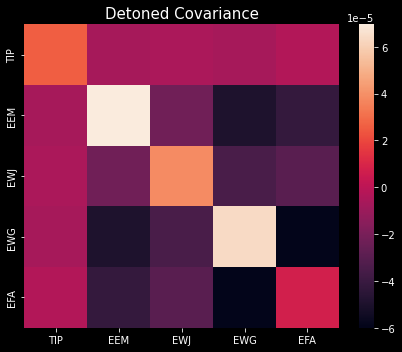

In [22]:
plt.figure(figsize=(6, 5))
sns.heatmap(cov_matrix_detoned)
plt.title('Detoned Covariance', size=15)
plt.tight_layout()
plt.savefig('cov_matrix_detoned.png', dpi=150)
plt.show()

The results of de-toning are significantly different from the de-noising results. This indicates that the deleted market component had an effect on the covariance between elements.

## Transforming covariance matrix to correlation matrix and back

These are simple functions to:
- transform covariance matrix into correlation matrix 
- transform correlation matrix into covariance matrix 

In [23]:
# Transforming our covariance matrix to a correlation matrix
corr_matrix = risk_estimators.cov_to_corr(cov_matrix)

# Outputting the result
print('The correlation matrix is:')
corr_matrix

The correlation matrix is:


,TIP,EEM,EWJ,EWG,EFA
TIP,1.000000,-0.211168,-0.224505,-0.424447,-0.367957
EEM,-0.211168,1.000000,0.723750,0.725180,0.823113
EWJ,-0.224505,0.723750,1.000000,0.671345,0.845424
EWG,-0.424447,0.725180,0.671345,1.000000,0.932142
EFA,-0.367957,0.823113,0.845424,0.932142,1.000000


In [24]:
# The standard deviation to use when calculating the covaraince matrix back
std = np.diag(cov_matrix) ** (1/2)

# And back to the covariance matrix
cov_matrix_again = risk_estimators.corr_to_cov(corr_matrix, std)

# Outputting the result
print('The covariance matrix calculated back is:')
cov_matrix_again

The covariance matrix calculated back is:


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000032,-0.000020,-0.000016,-0.000049,-0.000028
EEM,-0.000020,0.000290,0.000153,0.000252,0.000190
EWJ,-0.000016,0.000153,0.000153,0.000170,0.000142
EWG,-0.000049,0.000252,0.000170,0.000416,0.000257
EFA,-0.000028,0.000190,0.000142,0.000257,0.000183


In [25]:
print('Exactly the same as the original one:')
cov_matrix

Exactly the same as the original one:


,TIP,EEM,EWJ,EWG,EFA
TIP,0.000032,-0.000020,-0.000016,-0.000049,-0.000028
EEM,-0.000020,0.000290,0.000153,0.000252,0.000190
EWJ,-0.000016,0.000153,0.000153,0.000170,0.000142
EWG,-0.000049,0.000252,0.000170,0.000416,0.000257
EFA,-0.000028,0.000190,0.000142,0.000257,0.000183


## Conclusion

This notebook describes the functions implemented in the RiskEstimators class, related to different ways of calculating and adjusting the Covariance matrix. Also, it shows how the corresponding functions from the PortfolioLab library can be used and how the outputs can be analyzed.

Key takeaways from the notebook:
- A robust covariance estimator (such as the Minimum Covariance Determinant) is needed in order to discard/downweight the outliers in the data. These outliers seriously affect the Empirical covariance estimator and the Covariance estimators with shrinkage.
- The Maximum Likelihood Estimator (Empirical Covariance) of a sample is an unbiased estimator of the corresponding population’s covariance matrix.
- Shrinkage consists in reducing the ratio between the smallest and the largest eigenvalues of the empirical covariance matrix. It is used to avoid the problem with inversion of the covariance matrix.
- Ledoit-Wolf and Oracle Approximating are methods to calculate the optimal shrinkage coefficient $\alpha$ used in the Basic Shrinkage.
- The semi-covariance matrix is the way to measure the volatility of the negative returns or returns below a certain threshold. 
- Exponential Covariance is used to give greater weight to the most relevant observations in computing the covariance.
- The Constant Residual Eigenvalue De-noising Method calculates the eigenvalues of the correlation matrix and adjusts the ones that are lower than the theoretically estimated ones, as they are caused by noise.
- The Spectral Clustering De-noising Method works just like the Constant Residual Eigenvalue De-noising Method, But instead of lowering Eigenvalues below the theoretical maximum Eigenvalue, They are set to 0.
- The Targeted Shrinkage De-noising Method shrinks the eigenvectors/eigenvalues that are noise-related.
- The Hierarchical Clustering De-noising Method is used to filter empirical correlation matrices using Agglomerative Clustering.
- The De-toning algorithm excludes a number of first eigenvectors representing the market component. This allows a greater portion of the correlation to be explained by components that affect specific subsets of the securities. Note, that a de-toned correlation matrix cannot be used directly for mean-variance portfolio optimization.